# Udacity project: Write A Data Science Blog Post

## Perform required imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, make_scorer



pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline 

C:\Users\WGER\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\WGER\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Define required variables and functions

In [2]:
"""
    Define relevant variables based on qualitative analysis of the dataset
"""

# Global definitions
columns_excluded = ['id',
                    'listing_url', # url
                    'scrape_id',
                    'last_scraped',
                    'name', # unencodeable string
                    'summary', # unencodeable string
                    'space',# unencodeable string
                    'description',# unencodeable string
                    'neighborhood_overview', # unencodeable string
                    'notes', # unencodeable string  
                    'transit', # unencodeable string
                    'access', # unencodeable string
                    'house_rules', # unencodeable string
                    'picture_url', # url
                    'host_id', # hosts not relevant
                    'host_url', # hosts not relevant
                    'host_name', # hosts not relevant
                    'host_location', # hosts not relevant
                    'host_about', # hosts not relevant
                    'host_thumbnail_url', # hosts not relevant
                    'host_picture_url', # hosts not relevant
                    'host_total_listings_count', # Already hosts listing count available
                    'street', # Does only contain the information that appartment is in beijing
                    'city', # all Beijing
                    'state', # all Beijing
                    'market', # no additional information (all Beijing)
                    'smart_location', # no additional information (all Beijing)
                    'country_code', # no additional information (all Beijing)
                    'country', # no additional information (all Beijing)
                    'weekly_price', # only daily price relevant for model
                    'monthly_price', # only daily price relevant for model
                    'calendar_updated', # Date of last calendar update -> Probably not relevant
                    'has_availability', # Already included in availability
                    'availability_30', # Not relevant as we are looking at 365 days
                    'availability_60', # Not relevant as we are looking at 365 days
                    'availability_90', # Not relevant as we are looking at 365 days
                    'calendar_last_scraped', # Not relevant   

                    'experiences_offered', # All 'none'
                    'interaction', # unencodeable string
                    'host_neighbourhood', # neighbourhood_cleansed as best indicator for location
                    'neighbourhood',  # neighbourhood_cleansed as best indicator for location
                    'zipcode',  # eighbourhood_cleansed as best indicator for location

                    'amenities',   # Semistructured field, hard to evaluate
                    'host_verifications',  # Semistructured field, hard to evaluate

                    'jurisdiction_names', # all nans
                    'square_feet' # very seldomly filled
                   ]

columns_one_hot_encode = ['host_response_time',
                          'property_type',                          
                          'room_type',
                          'bed_type',
                          'cancellation_policy'
                         ]

columns_true_false = ['host_is_superhost',
                      'host_has_profile_pic',
                        'host_identity_verified',
                        'is_location_exact',
                        'requires_license',
                        'instant_bookable',
                        'is_business_travel_ready',
                        'require_guest_profile_picture',
                        'require_guest_phone_verification'
                     ]

columns_dollar_parser = ['price', 
                           'security_deposit', 
                           'cleaning_fee', 
                           'extra_people']

column_percentage_parse = ['host_response_rate',]

column_date_parse = ['host_since','first_review','last_review']

column_neighbourhood_translations = {
    '朝阳区 / Chaoyang': 'Chaoyang',
    '东城区': 'Dongcheng',
    '海淀区':'Haidian',
    '西城区':'Xicheng',
    '丰台区 / Fengtai':'Fengtai',
    '通州区 / Tongzhou':'Tongzhou',
    '昌平区':'Changping',
    '大兴区 / Daxing':'Daxing',
    '密云县 / Miyun':'Miyun',
    '怀柔区 / Huairou':'Huairou',
    '延庆县 / Yanqing':'Yanqing',
    '顺义区 / Shunyi':'Shunyi',
    '房山区':'Fangshan',
    '石景山区':'Shijingshan',
    '平谷区 / Pinggu':'Pinggu',
    '门头沟区 / Mentougou':'Mentougou'
}

column_neighbourhood_encoding = {
    'Chaoyang': 1,
    'Dongcheng':2,
    'Haidian':3,
    'Xicheng':4,
    'Fengtai':5,
    'Tongzhou':6,
    'Changping':7,
    'Daxing':8,
    'Miyun':9,
    'Huairou':10,
    'Yanqing':11,
    'Shunyi':12,
    'Fangshan':13,
    'Shijingshan':14,
    'Pinggu':15,
    'Mentougou':16
}

column_neighbourhood_encoding_reverse = {y:x for x,y in column_neighbourhood_encoding.items()}



# Define rows to drop in case of empty values (max 20 missing values)
missing_values_drop = ['host_since', 
                'host_listings_count', 
                'beds',
                'first_review',
                'last_review',
                'neighbourhood_cleansed' # More than 20. But only if neighbourhood available this feature is relevant
               ]


# Machine Learning pipeline
missing_values_replace_0 = ['security_deposit', 
                            'host_has_profile_pic',
                            'host_identity_verified',
                            'host_is_superhost',
                            'cleaning_fee',
                           'reviews_per_month']

missing_values_impute = ['host_response_rate',
                              'review_scores_rating',
                              'review_scores_accuracy',
                              'review_scores_cleanliness',
                              'review_scores_checkin',
                              'review_scores_communication',
                              'review_scores_location',
                              'review_scores_value',
                              'review_scores_value'
                             ]

In [3]:
def preprocess_for_analysis():
    """
        Preprocess data to be ready for analyis, including reading in the dataset, cleaning the data and renaming 
        values to a more userfriendly format
        Input:
            None
        Output:
            data (pd.dataframe) -> Preprocessed dataset for analysis
    """
    
    # Read in dataset
    df_preprocessed_analysis = pd.read_csv("./data/beijing/listings.csv", parse_dates=['host_since','first_review','last_review'])
    
    # Drop excluded columns
    df_preprocessed_analysis = df_preprocessed_analysis.drop(columns=columns_excluded)

    # Drop empty features
    df_preprocessed_analysis = df_preprocessed_analysis.dropna(axis=1, how='all')

    # Drop empty observation objects
    df_preprocessed_analysis = df_preprocessed_analysis.dropna(axis=0, how='all')
    
    # Drop rows based on missing values
    df_preprocessed_analysis = df_preprocessed_analysis.dropna(axis=0, how='any', subset=missing_values_drop)
    
    # Rename neighbourhoods to english
    df_preprocessed_analysis = df_preprocessed_analysis.replace({'neighbourhood_cleansed': column_neighbourhood_translations})

    # Handle date parse
    df_preprocessed_analysis[column_date_parse] = df_preprocessed_analysis[column_date_parse].values.astype(float)
    
    # Handle dollar parse
    for column in columns_dollar_parser:
        df_preprocessed_analysis[column] = df_preprocessed_analysis[column].str.replace('$','').str.replace(',','').astype(float)
        
    # Handle column_percentage_parse
    for column in column_percentage_parse:
        df_preprocessed_analysis[column] = df_preprocessed_analysis[column].str.replace('%','').astype(float)/100
        
    # Handle True and False Columns
    df_preprocessed_analysis[columns_true_false] = df_preprocessed_analysis[columns_true_false].replace({'f':0,'t':1}).astype(float)  
    
    
    return df_preprocessed_analysis

In [4]:
def impute_data(df):
    """
        Imputes dataframe

        Input:
            df (dataframe) -> dataframe to be imputed
        Ouput: 
            df_imputed (dataframe) -> imputed dataframe
    """
    imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
    df_imputed = pd.DataFrame(imputer.fit_transform(df.astype(np.float)))
    df_imputed.columns = df.columns
    return df_imputed

In [5]:
# Apply feature scaling to the general population demographics data.
def scale_data(df):
    """
        Scales dataframe

        Input:
            df (dataframe) -> dataframe to be scaled
        Ouput: 
            df (dataframe) -> scaled dataframe
    """
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df))
    df_scaled.columns = df.columns
    return df_scaled

In [6]:
def preprocess_for_machine_learning(df_preprocessed_analysis, prediction_feature):
    """
        Preprocess data already preprocessed for analysis to be ready for machine learning.
        Including hanling of dummy columns, treatment of 0-values and scaling of the data
        Input:
            df_preprocessed_analysis (pd.DataFrame) -> Already preprocessed dataset for analysis
        Output:
            X (pd.DataFrame) -> Preprocessed dataset of features for machine learning
            y (pd.Series) -> Preprocessed variable to predict for machine learning
    """
    
    X = df_preprocessed_analysis.drop(prediction_feature, axis = 1)
    y = df_preprocessed_analysis['neighbourhood_cleansed']
    
    # Rename neighbourhood_cleansed to categorial:
    y = y.replace(column_neighbourhood_encoding)
    
    
    
    # Handle dummy columns
    X = pd.get_dummies(X, columns=columns_one_hot_encode, dummy_na = True)
    
    # Replace 0 values
    X[missing_values_replace_0] = X[missing_values_replace_0].fillna(0)
    
    # Impute data for all others
    X = impute_data(X)
    
    # Scale data
    X = scale_data(X)
    
    X = X.drop(columns=['latitude','longitude'])

    
    return X,y

In [7]:
def feature_plot(importances, X_train, y_train):
    """
        Returns the 10 features of a model with the strongest weights and plots them
        Input:
            importances (object: RandomForestClassifier.feature_importances_) -> Feature importances (weights) of 
                                                                                    a RandomForestClassifier object
            X_train (pd.DataFrame) -> Features of the training set
            y_train (pd.Series) -> Labels of the training set
            
        Output:
            indices (np.ndarray) -> Indices of the feature weights
            columns (np.ndarray) -> Columns/Features of the feature weights
            weights (np.ndarray) -> Features
            
    """    
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    weights = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (15,10))
    plt.title("Normalized weights for first ten most predictive features", fontsize = 16)
    plt.bar(np.arange(10), weights, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(weights), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation='vertical')
    plt.xlim((-0.5, 9.5))
    plt.ylabel("weight", fontsize = 12)
    plt.xlabel("feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.savefig("figure3.png")
    plt.show()  
    
    return indices, columns, weights

## Preprocess data for analysis

In [8]:
prediction_feature = "neighbourhood_cleansed"

df_preprocessed_analysis = preprocess_for_analysis()
X, y = preprocess_for_machine_learning(df_preprocessed_analysis, prediction_feature)

## Q1: What are the relevant areas and how are apartments distributed?

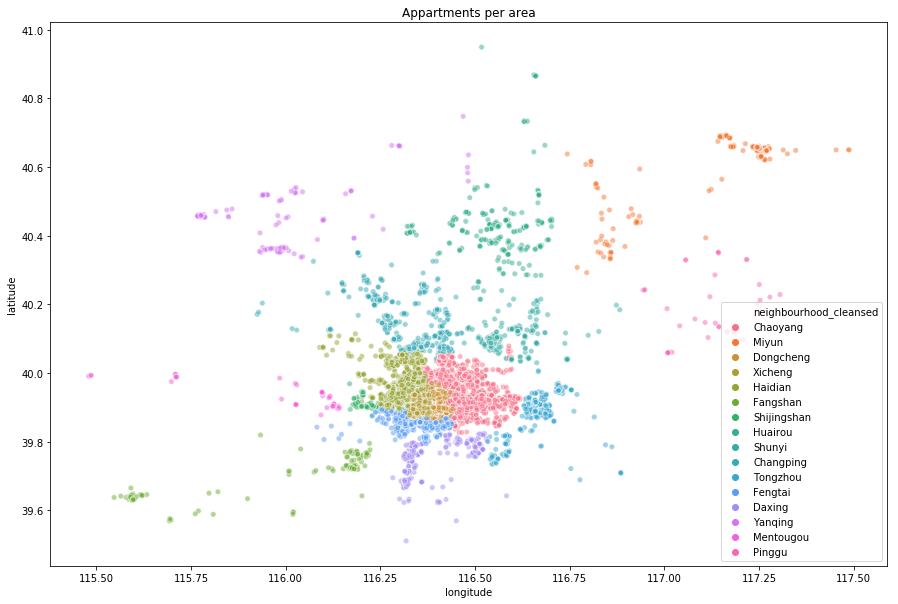

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x="longitude", y="latitude", hue="neighbourhood_cleansed", data=df_preprocessed_analysis, alpha=.5, s=30)
ax.set_title('Appartments per area')
plt.savefig("figure1.png")
plt.show()

In [10]:
neighbourhood_count = df_preprocessed_analysis['neighbourhood_cleansed'].value_counts().sort_values()

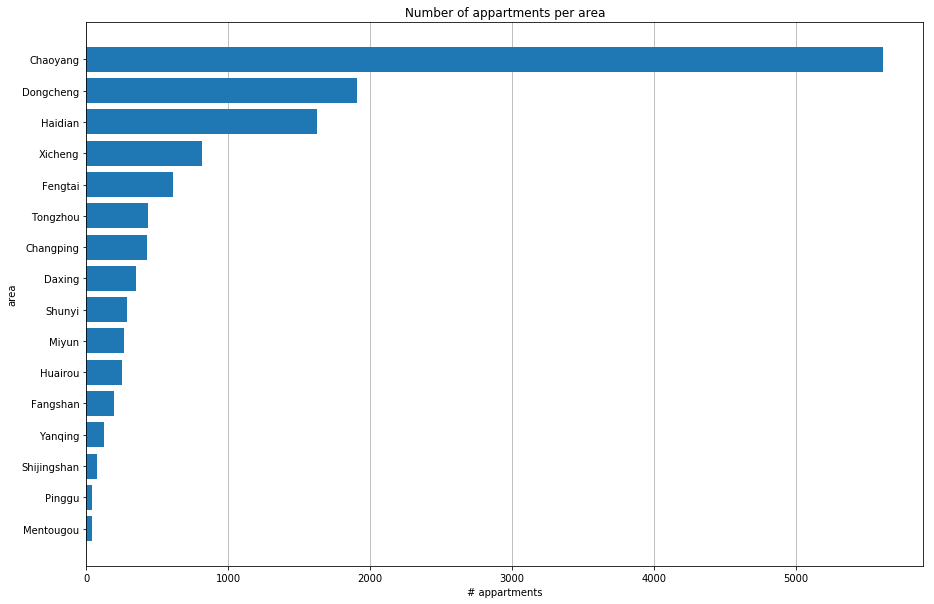

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(neighbourhood_count.keys(), neighbourhood_count.values)
ax.set_title('Number of appartments per area')
ax.set_xlabel('# appartments')
ax.set_ylabel('area')
ax.grid(axis='x')
ax.set_axisbelow(True)
#ax.set_xticklabels('KPI [Median]')
plt.savefig("figure2.png")
plt.show()

## Q2: What are key features connected to the area?

In [12]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 47)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 10460 samples.
Testing set has 2616 samples.


In [13]:
# Initialize the classifier
clf = RandomForestClassifier(random_state=47)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [10,40,100, 150],
               'max_depth': [4,6,8, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 5, 10]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5, average='micro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, param_grid = parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,  average='micro')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,  average='micro')))

Unoptimized model
------
Accuracy score on testing data: 0.5333
F-score on testing data: 0.5333

Optimized Model
------
Final accuracy score on the testing data: 0.5719
Final F-score on the testing data: 0.5719


In [14]:
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

print("Best score on training data:\t {:.4f}".format(accuracy_score(y_train,y_train_pred)))
print("Best score on test data:\t {:.4f}".format(accuracy_score(y_test,y_test_pred)))

Best score on training data:	 1.0000
Best score on test data:	 0.5719


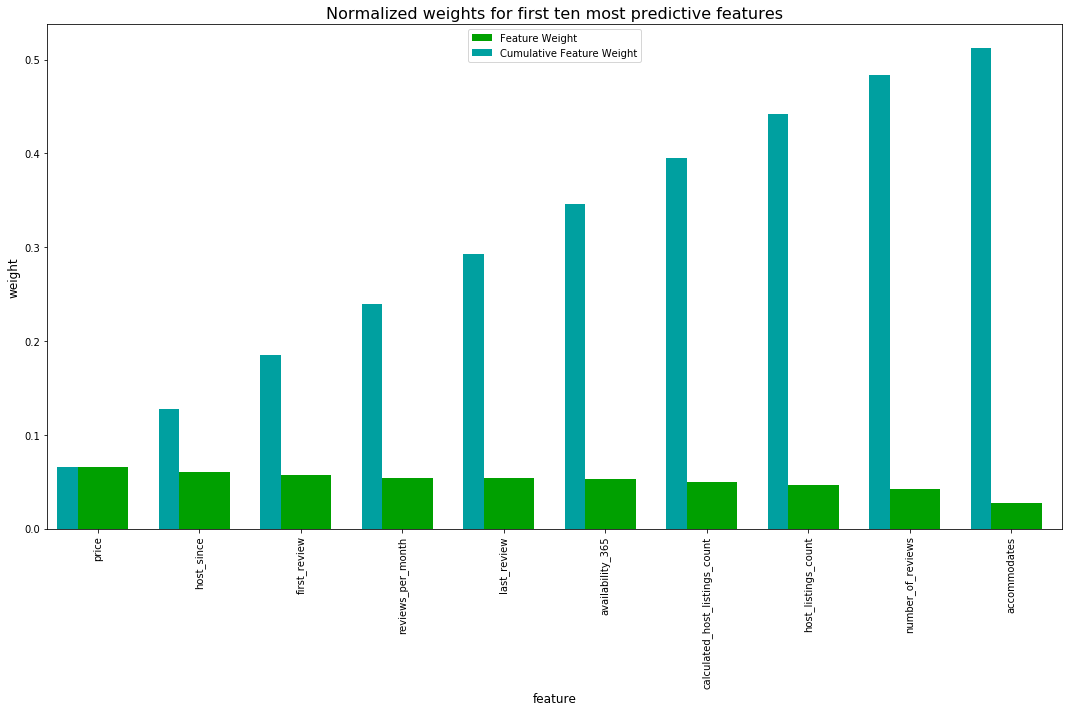

In [15]:
# Plot feature importances/weights
indices, columns, weights = feature_plot(clf.feature_importances_, X_train, y_train)

In [16]:
# Print weights for most important features
for column, weight in zip(columns, weights):
    print("'{}' has a weight of {:.4%}".format(column, weight))

'price' has a weight of 6.6206%
'host_since' has a weight of 6.0914%
'first_review' has a weight of 5.7738%
'reviews_per_month' has a weight of 5.4121%
'last_review' has a weight of 5.3520%
'availability_365' has a weight of 5.3207%
'calculated_host_listings_count' has a weight of 4.9269%
'host_listings_count' has a weight of 4.6970%
'number_of_reviews' has a weight of 4.2086%
'accommodates' has a weight of 2.7901%


## Q3: How is are prices distributed over the areas?

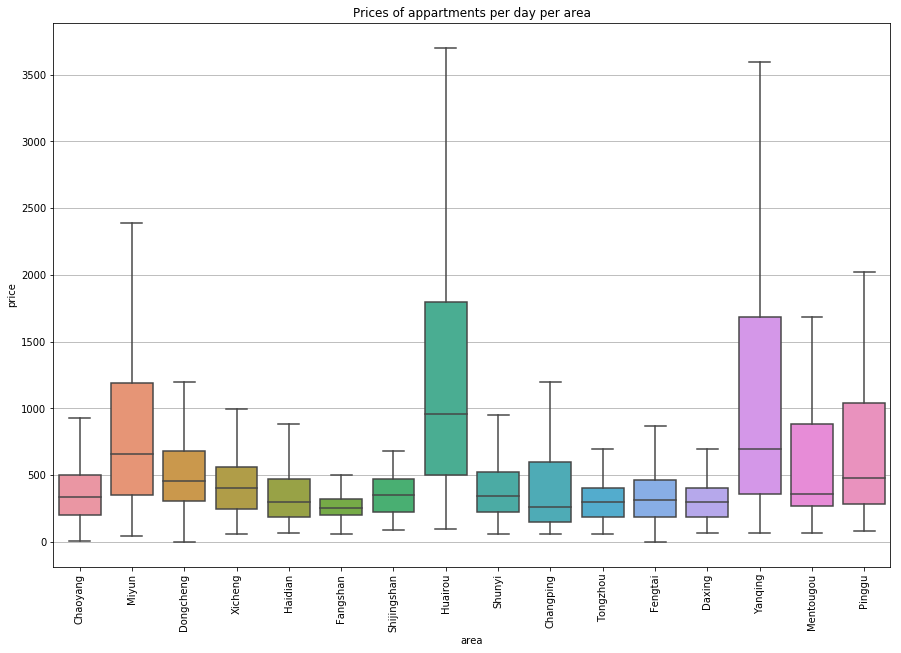

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='neighbourhood_cleansed', y='price' , data=df_preprocessed_analysis, ax=ax, showfliers=False)
ax.set_title('Prices of appartments per day per area')
plt.xticks(rotation='vertical')
ax.set_xlabel('area')
ax.set_ylabel('price')
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig("figure4.png")
plt.show()

# Backup

### Availability per area

In [18]:
neighbourhood_revenue_potential = df_preprocessed_analysis.groupby('neighbourhood_cleansed')['availability_365'].median().sort_values(ascending=True)

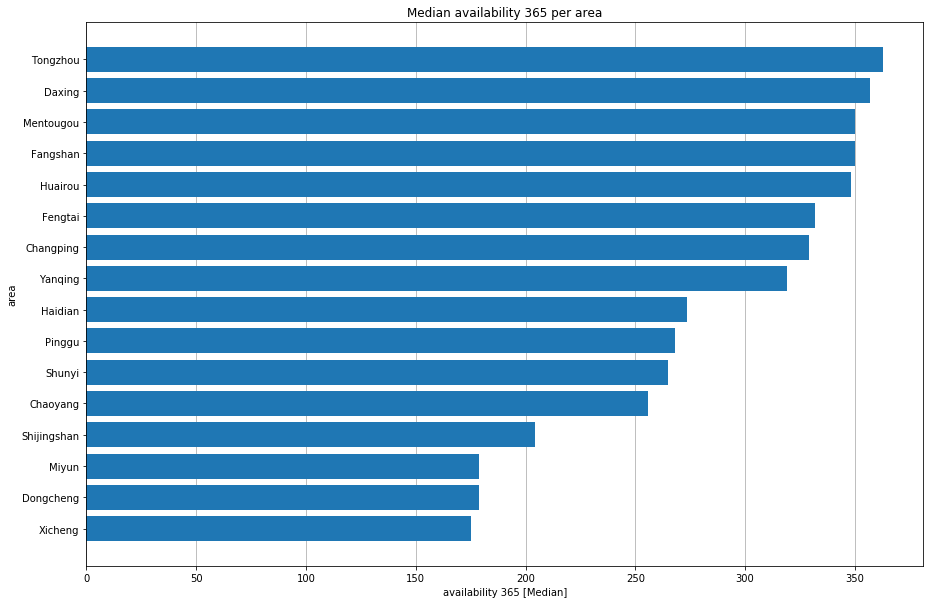

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(neighbourhood_revenue_potential.keys(), neighbourhood_revenue_potential.values)
ax.set_title('Median availability 365 per area')
ax.set_xlabel('availability 365 [Median]')
ax.set_ylabel('area')
ax.grid(axis='x')
ax.set_axisbelow(True)
#ax.set_xticklabels('KPI [Median]')
plt.show()

### Reviews per month per area

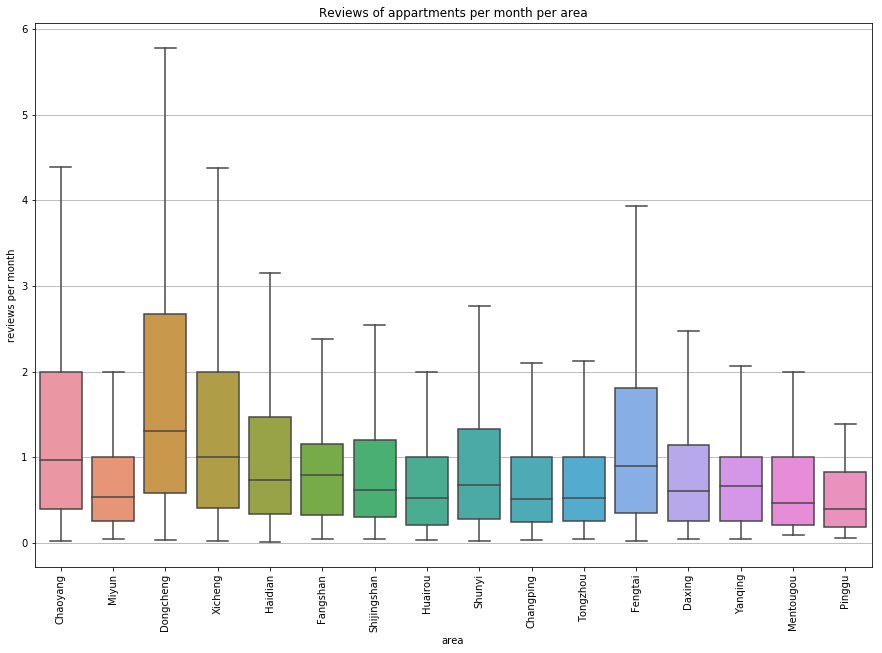

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='neighbourhood_cleansed', y='reviews_per_month' , data=df_preprocessed_analysis, ax=ax, showfliers=False)
ax.set_title('Reviews of appartments per month per area')
plt.xticks(rotation='vertical')
ax.set_xlabel('area')
ax.set_ylabel('reviews per month')
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

### Confusion matrix for classifier model

In [21]:
# Making the Confusion Matrix
y_test_names = np.vectorize(column_neighbourhood_encoding_reverse.get)(y_test)
y_test_pred_names = np.vectorize(column_neighbourhood_encoding_reverse.get)(y_test_pred)
pd.crosstab(y_test_names, y_test_pred_names, rownames=['Actual Neighbourhood'], colnames=['Predicted Neighbourhood'])

Predicted Neighbourhood,Changping,Chaoyang,Daxing,Dongcheng,Fangshan,Fengtai,Haidian,Huairou,Mentougou,Miyun,Shunyi,Tongzhou,Xicheng,Yanqing
Actual Neighbourhood,,,,,,,,,,,,,,
Changping,17,59,0,2,0,1,0,4,0,0,0,0,0,0
Chaoyang,1,1083,0,18,0,1,9,1,0,1,1,0,1,0
Daxing,4,66,7,0,0,0,0,0,0,0,0,0,0,0
Dongcheng,0,225,0,172,0,2,5,3,0,0,0,1,6,0
Fangshan,1,23,0,0,2,0,0,5,0,3,0,0,0,2
Fengtai,0,101,0,1,0,13,0,0,0,1,0,1,0,0
Haidian,0,218,0,7,0,0,94,1,0,0,0,1,0,0
Huairou,2,9,0,10,0,0,0,23,0,1,0,0,0,0
Mentougou,0,6,0,0,0,0,0,1,1,0,0,0,0,0
